In [4]:
import scanpy as sc

from pyprojroot import here

import seaborn as sns

import random 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import session_info

In [5]:
def lm_covariate_PCs(adata=None, embedding = ['X_pca'], covariates = None):
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LinearRegression

    resDF = pd.DataFrame()
    PCs = adata.obsm[embedding]
    for cov_i in covariates:
        dummieCov = pd.get_dummies(adata.obs[cov_i])        
        r2 = []
        for i in range(PCs.shape[1]):
            pc = PCs[:, [i]]
            lm = LinearRegression()
            lm.fit(dummieCov, pc)
            r2_score = np.maximum(0, lm.score(dummieCov, pc))
            r2.append(r2_score)
        resDF = pd.concat([resDF,pd.DataFrame(r2)], axis=1)
        
    resDF.columns = covariates
    return(resDF)

In [6]:
adata = sc.read_h5ad(here('03_downstream_analysis/04_integration_with_annotation/results/03_MAIN_geneUniverse_noRBCnPlatelets_embeddings.h5ad'))

In [7]:
adata

AnnData object with n_obs × n_vars = 4279352 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2', '_scvi_batch', '_scvi_labels'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'pca'
    obsm: 'X_pca_harmony', 'X_pca_scANVI_normalized_exp', 'X_pca_unintegrated', 'X_scANVI_latent', '_scvi_extra_categorical_covs', 'scgen_corrected_expression_pc', 'scgen_corrected_latent'
    varm: 'PCs'

In [8]:
resUncorrected = lm_covariate_PCs(adata=adata, embedding = 'X_pca_unintegrated', 
                                  covariates = ['disease', 'Level1', 'chemistry','studyID','binned_age', 'sex'])

In [9]:
resCorrected = lm_covariate_PCs(adata=adata, embedding = 'X_pca_scANVI_normalized_exp', 
                                  covariates = ['disease', 'Level1', 'chemistry','studyID','binned_age', 'sex'])

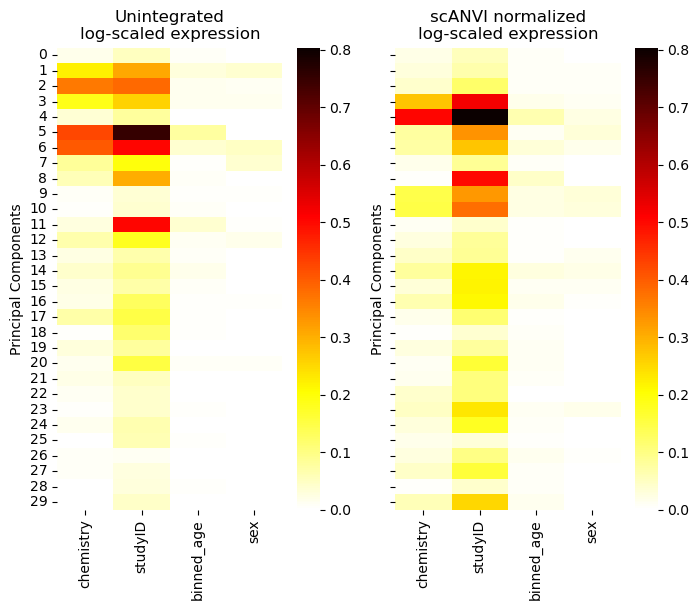

In [32]:
vmin = np.min([resUncorrected.loc[0:30,['chemistry','studyID','binned_age', 'sex']].min().min(), resCorrected.loc[0:30,['chemistry','studyID','binned_age', 'sex']].min().min()])
vmax = np.max([resUncorrected.loc[0:30,['chemistry','studyID','binned_age', 'sex']].max().max(), resCorrected.loc[0:30,['chemistry','studyID','binned_age', 'sex']].max().max()])

fig, axs = plt.subplots(ncols=2, figsize=(8, 6), sharey=True)  # Set the width and height of the figure

sns.heatmap(resUncorrected.loc[0:30,['chemistry','studyID','binned_age', 'sex']], ax=axs[0], cmap = 'hot_r', vmin=vmin, vmax=vmax)
axs[0].set_title('Unintegrated\nlog-scaled expression')
axs[0].set_ylabel('Principal Components')
axs[0].grid(False)

sns.heatmap(resCorrected.loc[0:30,['chemistry','studyID','binned_age', 'sex']], ax=axs[1], cmap = 'hot_r', vmin=vmin, vmax=vmax)
axs[1].set_title('scANVI normalized\nlog-scaled expression')
axs[1].set_ylabel('Principal Components')
axs[1].grid(False)

plt.savefig(here('03_downstream_analysis/04_integration_with_annotation/results/PCA_correlation_covariates.pdf'))  # Save the figure to a PDF file
plt.show()



In [11]:
session_info.show()